In [1]:
# mount google drive to see repository
import os

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

working_dir = '/content/drive/My Drive/github/BioCV_Su23/src'
os.chdir(working_dir)

Mounted at /content/drive


In [2]:
# set global vars for paths to save models
BEST_PATH = '/content/models/best'
CHKPT_PATH = '/content/models/checkpoints'

**Note**: This notebook is very experimental for prototyping. There is still a lot to do to make it work nicely.

In [3]:
!pip install onedrivedownloader pyyaml h5py torchsummary livelossplot

In [4]:
# basic needs
from onedrivedownloader import download
import nibabel as nib
import numpy as np
import random
import matplotlib.pyplot as plt
from google.colab import files

# custom utilities
from utils.make_autoencoder_dataset import create_ae_data_list, AutoencoderMRIDataset, ToTensor
from models.autoencoder import Autoencoder, autoencoder_training_loop, normalize_channels

# PyTorch
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from torchvision import transforms
# https://github.com/sksq96/pytorch-summary
from torchsummary import summary

In [5]:
# seeding
torch.manual_seed(100)
random.seed(100)
np.random.seed(100)

## Load the training and validation data sets

In [6]:
# define global vars
DATA_DIR = "/content/data/"  # places this in colab runtime storage instead of gdrive
!mkdir $DATA_DIR
IMG_REDUCED_DIR = os.path.join(DATA_DIR, "data", "images_annot_reduced_norm")
# IMAGES_ANNOT_REDUCED_URL = "https://rice-my.sharepoint.com/:u:/g/personal/hl9_rice_edu/EfqrvokObOJEhovsqLl_sscBgplo836OUdN5kJzAYqPZyg"
IMAGES_ANNOT_REDUCED_URL = "https://rice-my.sharepoint.com/:u:/g/personal/hl9_rice_edu/EccpxJhE8T5BgDkvbgUr6kIBPG0Nx9dneBeaqPPZ0YlZhw"
IMAGES_ANNOT_REDUCED_FN = "images_annot_reduced.zip"
STRUCT_SCANS = ["T1", "T2", "T1GD", "FLAIR"]

# download the reduced dataset if the files have not already been downloaded
if not os.path.exists(IMG_REDUCED_DIR):
    download(IMAGES_ANNOT_REDUCED_URL, filename=os.path.join(DATA_DIR, IMAGES_ANNOT_REDUCED_FN))

100%|██████████| 1.46G/1.46G [00:16<00:00, 89.0MiB/s]


Unzipping file...


Extracting files: 100%|██████████| 736/736 [00:08<00:00, 88.40it/s]


## PyTorch

### Create a custom data set and dataloader

In [7]:
# Create a data list
create_ae_data_list(data_dir=IMG_REDUCED_DIR)

Number of unique samples: 147


In [8]:
# create a custom data set for use with PyTorch DataLoader
custom_ae_mri_data = AutoencoderMRIDataset(
    data_dir=IMG_REDUCED_DIR,
    data_list_fn=os.path.join(IMG_REDUCED_DIR, "data_list.txt"),
    transforms=transforms.Compose([ToTensor()])
)

In [9]:
custom_ae_mri_data[0]

{'vol': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          ...,
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,


In [10]:
# confirm the shape of the tensor, expect CHWZ
custom_ae_mri_data[0]['vol'].shape

torch.Size([4, 163, 193, 146])

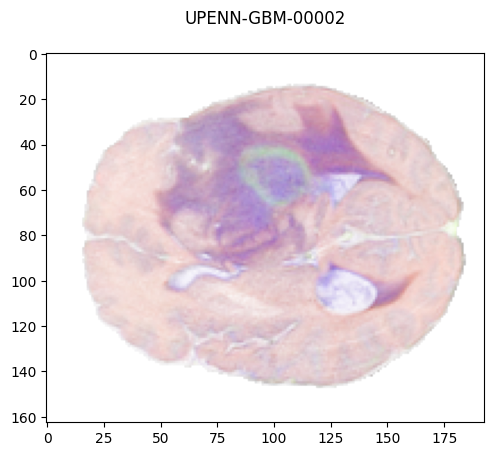

In [11]:
# display the first image
# plt.imshow(custom_ae_mri_data[0]['vol'].numpy().transpose((1, 2, 3, 0))[:, :, 73, :])
plt.imshow(custom_ae_mri_data[0]['vol'].permute((1, 2, 3, 0))[:, :, 73, :])
with open(os.path.join(IMG_REDUCED_DIR, "data_list.txt"), 'r') as file:
    plt.title(file.readline());

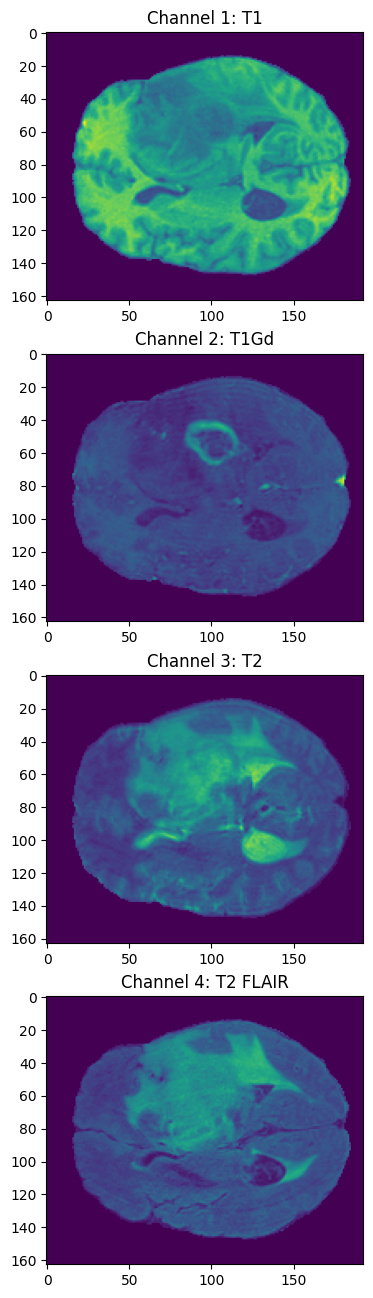

In [12]:
# show the four channels independently
fig, axs = plt.subplots(nrows=4, figsize=(6, 16))
axs[0].imshow(custom_ae_mri_data[0]['vol'].permute((1, 2, 3, 0))[:, :, 73, 0], vmin=0, vmax=1)
axs[0].set_title('Channel 1: T1')
axs[1].imshow(custom_ae_mri_data[0]['vol'].permute((1, 2, 3, 0))[:, :, 73, 1], vmin=0, vmax=1)
axs[1].set_title('Channel 2: T1Gd')
axs[2].imshow(custom_ae_mri_data[0]['vol'].permute((1, 2, 3, 0))[:, :, 73, 2], vmin=0, vmax=1)
axs[2].set_title('Channel 3: T2')
axs[3].imshow(custom_ae_mri_data[0]['vol'].permute((1, 2, 3, 0))[:, :, 73, 3], vmin=0, vmax=1)
axs[3].set_title('Channel 4: T2 FLAIR')
plt.show()

In [9]:
# set up data loader
batch_size = 32
dataloader = DataLoader(custom_ae_mri_data, batch_size=batch_size, shuffle=True)

In [15]:
# iterate over each batch and inspect the size is as expected
for i_batch, sampled_batch in enumerate(dataloader):
    print(i_batch, sampled_batch['vol'].size())

0 torch.Size([32, 4, 163, 193, 146])
1 torch.Size([32, 4, 163, 193, 146])
2 torch.Size([32, 4, 163, 193, 146])
3 torch.Size([32, 4, 163, 193, 146])
4 torch.Size([19, 4, 163, 193, 146])


These results match what is expected, and most importantly, the memory has not been significantly used up since each volume is being accessed on-demand instead of all-at-once.

### Train autoencoder

In [14]:
# Instantiate the model
model = Autoencoder(version='v1')

In [15]:
print(model)

Autoencoder(
  (encoder): Sequential(
    (0): Conv3d(4, 3, kernel_size=(1, 1, 1), stride=(1, 1, 1), padding=same)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose3d(3, 4, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  )
)


In [16]:
# get model summary using torchsummary (similar to keras api summary for TF2)
# need to send model to device first or else there will be a mismatch in dtypes
# https://stackoverflow.com/questions/59013109/runtimeerror-input-type-torch-floattensor-and-weight-type-torch-cuda-floatte
if torch.cuda.is_available():
    summary(model.cuda(), input_size=(4, 163, 193, 146))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [-1, 3, 163, 193, 146]              15
              ReLU-2     [-1, 3, 163, 193, 146]               0
   ConvTranspose3d-3     [-1, 4, 163, 193, 146]              16
Total params: 31
Trainable params: 31
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 70.08
Forward/backward pass size (MB): 350.42
Params size (MB): 0.00
Estimated Total Size (MB): 420.50
----------------------------------------------------------------


In [17]:
# specify the loss function
loss_fn = nn.MSELoss()

# create an optimizer
optimizer = torch.optim.Adam(model.parameters())  # use default lr=0.001

note: Using batch size of 32 and 5 training epochs takes ~7 minutes (420 seconds) for the baseline autoencoder $\leftarrow$ ~1.4 mins / epoch.

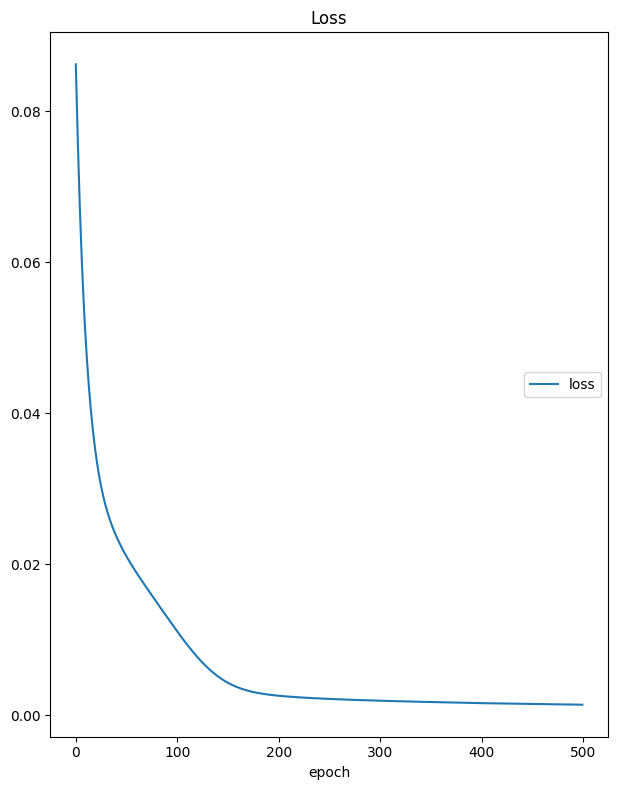

Loss
	loss             	 (min:    0.001, max:    0.086, cur:    0.001)


In [18]:
# call the training loop
autoencoder_training_loop(
    model,
    loss_fn,
    optimizer,
    dataloader,
    nepochs=500,
    name='v1_model',
    chkpt_path=CHKPT_PATH,
    best_path=BEST_PATH
)

In [19]:
# download the last best model
final_best = sorted(os.listdir(BEST_PATH))[-1]
final_best_path = os.path.join(BEST_PATH, final_best)
final_best_zip_path = os.path.join(BEST_PATH, final_best + ".zip")
!zip $final_best_zip_path $final_best_path
files.download(final_best_zip_path)

# download the last checkpoint model
final_chkpt = sorted(os.listdir(CHKPT_PATH))[-1]
final_chkpt_path = os.path.join(CHKPT_PATH, final_chkpt)
final_chkpt_zip_path = os.path.join(CHKPT_PATH, final_chkpt + ".zip")
!zip $final_chkpt_zip_path $final_chkpt_path
files.download(final_chkpt_zip_path)

shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
  adding: content/models/best/v1_model_current_best_epoch_500.pt (deflated 61%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
  adding: content/models/checkpoints/v1_model_checkpoint_epoch_500.pt (deflated 61%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Inference & analysis

At this point, typically it is best to restart the kernel, re-run all cells prior to training, and then start here for inference using the fitted model

In [10]:
# load saved model
model = Autoencoder()
model.load_state_dict(torch.load("../fitted_models/autoencoder/v1_model_current_best_epoch_500.pt"))
model.eval()  # set to evaluation for inference

Autoencoder(
  (encoder): Sequential(
    (0): Conv3d(4, 3, kernel_size=(1, 1, 1), stride=(1, 1, 1), padding=same)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose3d(3, 4, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (1): Sigmoid()
  )
)

In [11]:
# send the model to GPU
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

Autoencoder(
  (encoder): Sequential(
    (0): Conv3d(4, 3, kernel_size=(1, 1, 1), stride=(1, 1, 1), padding=same)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose3d(3, 4, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (1): Sigmoid()
  )
)

In [12]:
# let's see what a reconstructed image looks like for the first input
reconstructed = model(custom_ae_mri_data[0]['vol'].to(torch.device("cuda"), dtype=torch.float))

In [13]:
print(f"input summary stats:\n min: {custom_ae_mri_data[0]['vol'].min()}\n max: {custom_ae_mri_data[0]['vol'].max()}\n mean: {custom_ae_mri_data[0]['vol'].mean()}")

input summary stats:
 min: 0.0
 max: 0.9999999997671694
 mean: 0.10280993230253377


In [14]:
print(f"reconstructed summary stats:\n min: {reconstructed.min()}\n max: {reconstructed.max()}\n mean: {reconstructed.mean()}")

reconstructed summary stats:
 min: 0.4997161328792572
 max: 0.7299203872680664
 mean: 0.525229275226593


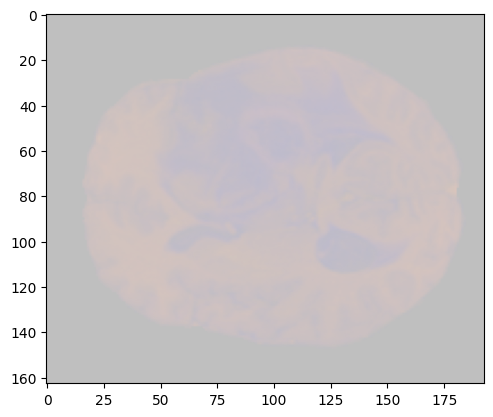

In [15]:
plt.imshow(reconstructed.cpu().detach().numpy().transpose(1, 2, 3, 0)[:, :, 73, :]);

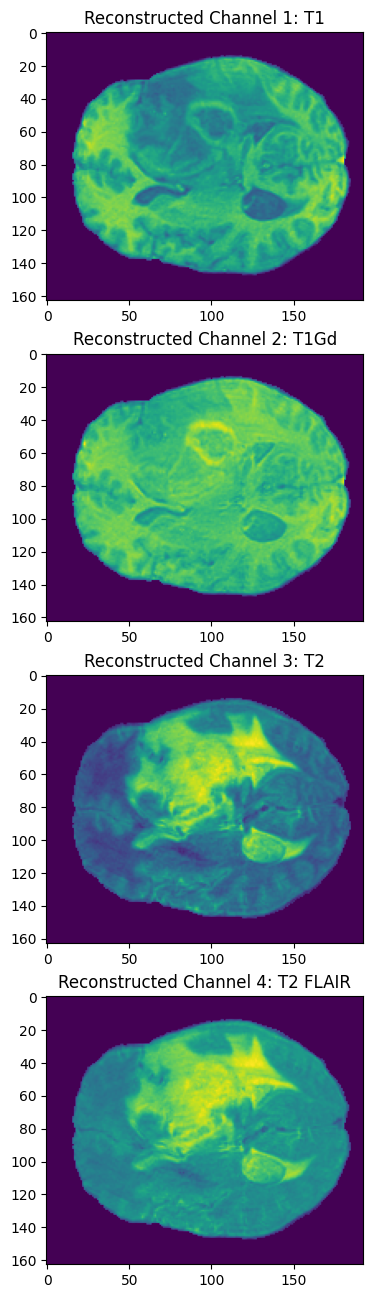

In [17]:
# show the four channels independently
reconstructed_np = reconstructed.cpu().detach().numpy().transpose(1, 2, 3, 0)
fig, axs = plt.subplots(nrows=4, figsize=(6, 16))
axs[0].imshow(reconstructed_np[:, :, 73, 0])
axs[0].set_title('Reconstructed Channel 1: T1')
axs[1].imshow(reconstructed_np[:, :, 73, 1])
axs[1].set_title('Reconstructed Channel 2: T1Gd')
axs[2].imshow(reconstructed_np[:, :, 73, 2])
axs[2].set_title('Reconstructed Channel 3: T2')
axs[3].imshow(reconstructed_np[:, :, 73, 3])
axs[3].set_title('Reconstructed Channel 4: T2 FLAIR')
plt.show()

In [63]:
# normalize the channels of the reconstructed data
normalized_reconstructed = normalize_channels(reconstructed)

In [64]:
print(f"reconstructed summary stats:\n min: {normalized_reconstructed.min()}\n max: {normalized_reconstructed.max()}\n mean: {normalized_reconstructed.mean()}")

reconstructed summary stats:
 min: 0.0
 max: 1.0
 mean: 0.22670258581638336


In [18]:
# what is the latent space representation?
latent_space_rep = model.encoder(custom_ae_mri_data[0]['vol'].to(torch.device("cuda" if torch.cuda.is_available() else "cpu"), dtype=torch.float))

In [66]:
latent_space_rep.size()

torch.Size([3, 163, 193, 146])

In [67]:
print(f"Latent space summary stats:\n min: {latent_space_rep.min()}\n max: {latent_space_rep.max()}\n mean: {latent_space_rep.mean()}")

Latent space summary stats:
 min: 0.0
 max: 1.1427910327911377
 mean: 0.5538411140441895


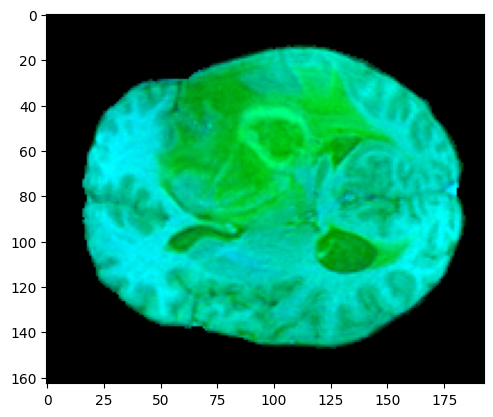

In [19]:
# visualize
plt.imshow(latent_space_rep.cpu().detach().numpy().transpose((1, 2, 3, 0))[:, :, 73, :]);

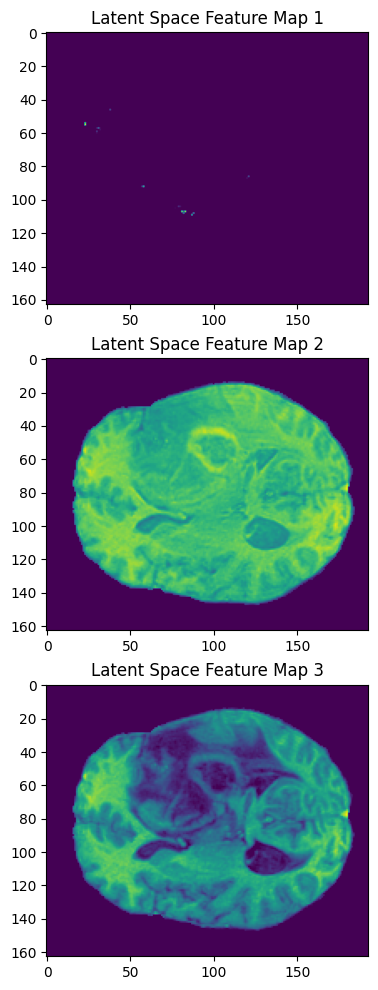

In [20]:
# show the three channels separately
fig, axs = plt.subplots(nrows=3, figsize=(6, 12))
axs[0].imshow(latent_space_rep.cpu().detach().numpy().transpose((1, 2, 3, 0))[:, :, 73, 0])
axs[0].set_title('Latent Space Feature Map 1')
axs[1].imshow(latent_space_rep.cpu().detach().numpy().transpose((1, 2, 3, 0))[:, :, 73, 1])
axs[1].set_title('Latent Space Feature Map 2')
axs[2].imshow(latent_space_rep.cpu().detach().numpy().transpose((1, 2, 3, 0))[:, :, 73, 2])
axs[2].set_title('Latent Space Feature Map 3')
plt.show()